In [1]:
#@title _This cell installs several packages needed in the Notebook._
%%capture
! sudo apt update
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
%pip install py3Dmol pubchempy chempy
%pip install --prefer-binary pyscf
%pip install pyscf[geomopt,dispersion]

In [9]:
#@title _Constants and functions used in this Notebook_

# Defining some constants
m_u    = 1.66053886e-27      # atomic mass constant in kg
h      = 6.6260693e-34       # Planck's constant in J*s
k_B    = 1.3806505e-23       # Boltzmann's constant in J/K
c      = 2.99792558e8        # Speed of light in m/s
bar2Pa = 1e5                 # 1 bar to N/m**2
Pa2bar = 1e-5                # 1 Pa=N/m**2 to bar
p0     = 1                   # standard pressure in bar
R      = 8.31447e-3          # Gas constant in kJ/(K mol)
H2kcal = 627.509             # Hartree to kcal/mol
H2kJ   = 2625.5              # Hartree to kJ/mol
Rbar   = 0.0831447           # R in bar L / (mol K)
Rkcal  = 1.9872036e-3        # R in kcal mol-1 K-1

import numpy as np
import matplotlib.pyplot as plt

def deltaG1_T(DH0,DS0,delta_nu,T):
  theta = 298.15 / T
  return DH0 - T * DS0 +  4 * delta_nu * R * T * ( 1 - theta + np.log(theta))

def deltaG2_T(DH0,DS0,delta_nu,T):
  theta = 298.15 / T
  return DH0 - T * DS0 - 2 * delta_nu * R * T * (theta - 1) ** 2

def G_m_0(temp,m,A,B,C,lin_A,nat_A,sigma,spin,*freq):
  import math
  q_t = (2*math.pi*m*m_u*k_B*temp/h/h)**1.5*k_B*temp/bar2Pa
  q_r = 1 ; q_v = 1 ; Sr = 0 ; Sv = 0 ; Ur = 0 ; Uv = 0
  if nat_A > 1:
    rA  = h * c * 100 * A / k_B
    rB  = h * c * 100 * B / k_B
    rC  = h * c * 100 * C / k_B
    if lin_A == 0:
      q_r = 1 / sigma * math.sqrt(math.pi)*(temp**1.5/math.sqrt(rA*rB*rC))
    else:
      if rA == 0:
        rl = math.sqrt(rB*rC)
      elif rB == 0:
        rl = math.sqrt(rA*rC)
      else:
        rl = math.sqrt(rA*rB)
      q_r = 1 / sigma * temp / rl
    for ele in freq:
      rv   = h * c * 100 * float(ele) / k_B
      q_v *= 1 / (1 - np.exp(-rv/temp))
  q_e = spin + 1
  q = q_t * q_r * q_v * q_e
  return - R * temp * np.log(q)

def S_m_0(temp,m,A,B,C,lin_A,nat_A,sigma,spin,*freq):
  import math
  q_t = (2*math.pi*m*m_u*k_B*temp/h/h)**1.5*k_B*temp/bar2Pa
  St = R * (np.log(q_t) + 2.5)
  q_r = 1 ; q_v = 1 ; Sr = 0 ; Sv = 0
  if nat_A > 1:
    rA  = h * c * 100 * A / k_B
    rB  = h * c * 100 * B / k_B
    rC  = h * c * 100 * C / k_B
    if lin_A == 0:
      q_r = 1 / sigma * math.sqrt(math.pi)*(temp**1.5/math.sqrt(rA*rB*rC))
      Sr = R * (1.5 + np.log(q_r))
    else:
      if rA == 0:
        rl = math.sqrt(rB*rC)
      elif rB == 0:
        rl = math.sqrt(rA*rC)
      else:
        rl = math.sqrt(rA*rB)
      q_r = 1 / sigma * temp / rl
      Sr = R * (1 + np.log(q_r))
    for ele in freq:
      rv   = h * c * 100 * float(ele) / k_B
      q_v *= 1 / (1 - np.exp(-rv/temp))
      Sv  += R * (rv / temp / (np.exp(rv/temp) - 1) - np.log(1 - np.exp(-rv/temp)) )
  q_e = spin + 1
  S_e = R * np.log(q_e)
  S = St + Sr + Sv + S_e
  return S

def deltaG_comput_t(temp):
  gcorr = []
  g = []
  for k,ele in enumerate(keys):
    gcorr.append(G_m_0(temp,sum(mass[k]),A[k],B[k],C[k],lin[k],natom[k],sigma[k],spin[k],*freq_info[k]['freq_wavenumber']))
    g.append( (e0[k] +zpe[k]) * H2kJ + gcorr[k] )
  return 2 * g[1] - g[0]

In [3]:
#@title Using [Chempy](https://pypi.org/project/chempy/)

from operator import mul
from functools import reduce
from itertools import product
import chempy
from chempy import Substance
from chempy.chemistry import Species, Equilibrium, Reaction
from chempy.equilibria import EqSystem, NumSysLog, NumSysLin
from chempy import balance_stoichiometry
import numpy as np
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt

temp = 298.15
reactf='N2O4'
prodf='NO2'
spin=[]
react = Substance.from_formula(reactf)
prod  = Substance.from_formula(prodf)
#print("Reactant:",react.unicode_name)
#print("Product :",prod.unicode_name)
spin_react=spin_prod=0
for ele in react.composition.keys(): spin_react += ele * react.composition[ele]
spin.append(spin_react % 2)
for ele in prod.composition.keys(): spin_prod += ele * prod.composition[ele]
spin.append(spin_prod % 2)
print("Spin list:",spin)

reac, pr = balance_stoichiometry({reactf},{prodf})

equilibrium = Equilibrium(reac, pr)

keys = [reactf,prodf]

subst = {k: Substance.from_formula(k) for k in keys}

r_latex=equilibrium.latex(subst)
r_unicode=equilibrium.unicode(subst)
print(r_unicode)


Spin list: [0, 1]
N₂O₄ ⇌ 2 NO₂


In [4]:
#@title Retrieving structures of reactant and product from [PubChem](https://pubchem.ncbi.nlm.nih.gov/)
import pubchempy as pcp

keys1=['N2O4', 'nitrogen dioxide']
#print(keys)
#print(keys1)
natom = []
for k,ele in enumerate(keys1):
  molA = ele
  #molA = input('Name of your substance: ')
  queryA0 = pcp.get_compounds(molA,'name')
  queryA = pcp.get_compounds(molA,'name',record_type='3d')
  if(len(queryA)==0): queryA = queryA0
  cid_A = pcp.get_cids(molA)
  if len(cid_A) == 0: print('Molecule not found')
  else: print('CID of',Substance.from_formula(keys[k]).unicode_name,': ',cid_A)

  m = queryA[0]
  natom.append(len(m.atoms))
  f = open(keys[k]+'.xyz','w')
  if natom[k] > 1:
    f.write(str(natom[k])+'\n\n')
    for i,a in enumerate(m.atoms):
      if a.z is None: a.z = 0.0
      f.write(m.elements[i]+' '+str(a.x)+' '+str(a.y)+' '+str(a.z)+'\n')
  else:                            f.write(m.elements[0]+' 0. 0. 0.\n')
  f.close()

CID of N₂O₄ :  [25352]
CID of NO₂ :  [3032552]


In [5]:
#@title _Using [pyscf](https://pyscf.org) to optimize the structures at the desidred DFT level of theory._
%%capture
from pyscf import gto, scf
from pyscf.hessian import thermo
from pyscf.geomopt.geometric_solver import optimize

import os


e0 = []
e0nd = []
zpe = []
lin = []
A = []
B = []
C = []
freq_info = []
mass = []
sigma = []
mol_eq = []
thermos = []

functional ='o3lyp-d4'
for k,ele in enumerate(keys):
  mol = gto.M(atom = ele+".xyz",spin=spin[k],basis='6-31g*')
  if spin[k] == 0: mf = mol.RKS(xc=functional)
  else: mf = mol.UKS(xc=functional)

  mf.grids.level = 5

# optimization
  mol_eq.append(optimize(mf, maxsteps=100))

  if spin[k] == 0: mf = mol_eq[k].RKS(xc=functional).run()
  else: mf = mol_eq[k].UKS(xc=functional).run()

  mf.grids.level = 5

  hessian = mf.Hessian().kernel()

  freq_info.append(thermo.harmonic_analysis(mf.mol, hessian))
  thermo_info = thermo.thermo(mf, freq_info[k]['freq_au'], temp, 101325)
  mass.append(mol.atom_mass_list(isotope_avg=True))
  rot_info = thermo.rotation_const(mass[k],mol_eq[k].atom_coords())
  sigma.append(thermo.rotational_symmetry_number(mol_eq[k]))

  A.append(rot_info[0] * 0.033357)
  B.append(rot_info[1] * 0.033357)
  C.append(rot_info[2] * 0.033357)
  if A[k] == B[k] and C[k] <= 0.001: lin.append(1)
  else: lin.append(0)

  e0.append(thermo_info['E0'][0])
  zpe.append(thermo_info['ZPE'][0])
  thermos.append(thermo_info)

Frequencies of N₂O₄ (cm^-1)
        93
       216
       281
       431
       490
       683
       757
       841
      1346
      1482
      1868
      1891

Frequencies of NO₂ (cm^-1)
       753
      1415
      1759

deltaG:  5.38549 kJ/mol
deltaH: 58.27804 kJ/mol
deltaS:  0.17740 kJ/mol


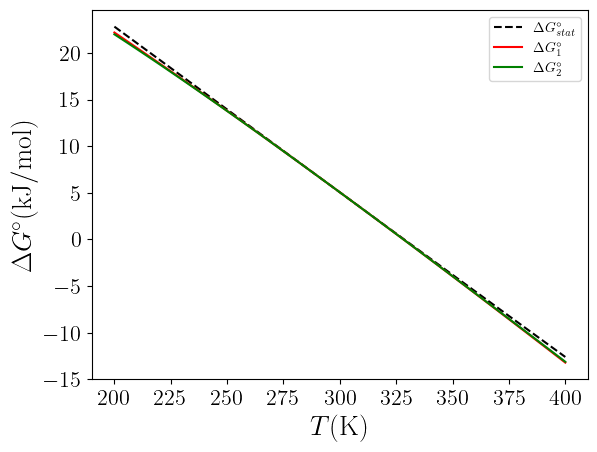

In [14]:
#@title Computing $\Delta G^{\circ}$ using the RRHO approximation and further approximations explained above ($\Delta G^{\circ}_1$ and $\Delta G^{\circ}_2$)

import IPython

gcorr = []
g = []
enthal = []
s = []

temp = 298.15
for k,ele in enumerate(keys):
  gcorr.append(G_m_0(temp,sum(mass[k]),A[k],B[k],C[k],lin[k],natom[k],sigma[k],spin[k],*freq_info[k]['freq_wavenumber']))
  g.append( (e0[k] + zpe[k]) * H2kJ + gcorr[k] )
  s.append(S_m_0(temp,sum(mass[k]),A[k],B[k],C[k],lin[k],natom[k],sigma[k],spin[k],*freq_info[k]['freq_wavenumber']))
  print('Frequencies of',Substance.from_formula(ele).unicode_name,'(cm^-1)')
  for ifreq in freq_info[k]['freq_wavenumber']:
    print('%10.0f' % ifreq)
  gto.tofile(mol_eq[k],str(keys[k])+'_opt.xyz')
  print("")

deltaG = (2 * g[1] - g[0])
deltaS = (2 * s[1] - s[0])
deltaH = deltaG  + temp * deltaS

print('deltaG: %8.5f kJ/mol' % deltaG)
print('deltaH: %8.5f kJ/mol' % deltaH)
print('deltaS: %8.5f kJ/mol' % deltaS)

T = np.linspace(200,400,100)

plt.rcParams['text.usetex'] = True

plt.plot(T,deltaG_comput_t(T),'--',color='black',label='$\Delta G^{\circ}_{stat}$')
plt.plot(T,deltaG1_T(deltaH,deltaS,1,T),color='red',label='$\Delta G^{\circ}_1$')
plt.plot(T,deltaG2_T(deltaH,deltaS,1,T),color='green',label='$\Delta G^{\circ}_2$')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('$\Delta G^{\circ} (\mathrm{kJ/mol})$',fontsize=20)
plt.xlabel('$T (\mathrm{K})$',fontsize=20)
plt.legend()
plt.savefig("deltaG.svg",bbox_inches='tight')

plt.show()

In [11]:
#@title _Visualization of the optimized reactant_
import py3Dmol

view = py3Dmol.view(width=500, height=500)
view.addModel(open('N2O4_opt.xyz', 'r').read(), 'xyz')
view.setStyle({'stick':{'singleBonds' : 'False'},'sphere': {'scale': 0.3}})
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
#@title _Visualization of the optimized product_

view = py3Dmol.view(width=500, height=500)
view.addModel(open('NO2_opt.xyz', 'r').read(), 'xyz')
view.setStyle({'stick':{'singleBonds' : 'False'},'sphere': {'scale': 0.3}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.